# Human Activity Recognotion (HAR)

* Problem statement

  Given sequences of sensor measurements, find the activity type.

* Notebook Structure

  * Data
    * Download
    * EDA
    * Pre-process
  * Model 
    * Define the model
    * Train the model
  * Results
  * Further Experiments
    * Tune hyperparameters.


* Dataset

  Human Activity Recognition Using Smartphones Data Set, UCI Machine Learning Repository https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones

* References
  * Davide Anguita, Alessandro Ghio, Luca Oneto, Xavier Parra and Jorge L. Reyes-Ortiz. A Public Domain Dataset for Human Activity Recognition Using Smartphones. 21th European Symposium on Artificial Neural Networks, Computational Intelligence and Machine Learning, ESANN 2013. Bruges, Belgium 24-26 April 2013. https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones
  * 1D Convolutional Neural Network Models for Human Activity Recognition by Machine Learning Mastery https://machinelearningmastery.com/cnn-models-for-human-activity-recognition-time-series-classification/

  * The basics of using KerasTuner to tune model hyperparameters https://keras.io/guides/keras_tuner/getting_started/


## Data

In [1]:
import numpy as np
import pickle as pk
import tensorflow as tf
import os

In [3]:
print(tf.__version__)

2.16.1


### Data Loading

* The data consists of three main components--total acceleration, body acceleration, and body gyroscope--each of which has x, y, and z measurement. So there are 9 variable for data at each time step.

* The data was measured at 50Hz and grouped into overlapping windows of 2.56 seconds. So each window has 128 (2.56 by 50) time steps. 

* Each row of data has 1152 (128 by 9) elements. 

In [2]:
# import libraries
from numpy import mean
from numpy import std
from numpy import dstack
from numpy import array
from numpy import vstack

from pandas import read_csv
from pandas import DataFrame

import matplotlib.pyplot as plt

In [3]:
from tensorflow.keras.utils import to_categorical

In [4]:
# load a single file as a numpy array
def load_file(filepath):
	dataframe = read_csv(filepath, header=None, sep=r'\s+')
	return dataframe.values

In [5]:
# load a list of files into a 3D array of [samples, timesteps, features]
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = dstack(loaded)
	return loaded

In [6]:
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
	filepath = prefix + group + '/InertialSignals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + group + '/y_'+group+'.txt')
	return X, y

Since the output of the dataset was defined with integer, as class number, 
* offset the values so that the class label starts with zero
* one hot encode the values using keras to_categorial() function so that it can work with keras multiclass classification model 

In [7]:
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
	# load all train
	trainX, trainy = load_dataset_group('train', prefix + 'dataset/')
	#print(trainX.shape, trainy.shape)
	# load all test
	testX, testy = load_dataset_group('test', prefix + 'dataset/')
	#print(testX.shape, testy.shape)
	# zero-offset class values
	trainy = trainy - 1
	testy = testy - 1
	# one hot encode y
	#trainy = to_categorical(trainy)
	#testy = to_categorical(testy)
	print(trainX.shape, trainy.shape, testX.shape, testy.shape)
	return trainX, trainy, testX, testy

In [8]:
trainX, trainy, testX, testy = load_dataset() # prints out the shape of trainX, trainy, testX, testy

(7352, 128, 9) (7352, 1) (2947, 128, 9) (2947, 1)


Further divide train set to train and validation sets.

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
trainX, validX, trainy, validy = train_test_split(trainX, trainy, test_size=0.19, random_state=42)

In [11]:
trainX.shape

(5955, 128, 9)

In [20]:
trainy.shape

(5955, 1)

In [21]:
trainy[0]

array([0])

In [22]:
validX.shape

(1397, 128, 9)

In [23]:
validy.shape

(1397, 1)

### Exploratory Data Analysis

The following function for EDA came from (https://machinelearningmastery.com/how-to-model-human-activity-from-smartphone-data/)

In [11]:
# summarize the balance of classes in an output variable column
def class_breakdown(data):
 # convert the numpy array into a dataframe
 df = DataFrame(data)
 # group data by the class value and calculate the number of rows
 counts = df.groupby(0).size()
 # retrieve raw rows
 counts = counts.values
 # summarize
 for i in range(len(counts)):
  percent = counts[i] / len(df) * 100
  print('Class=%d, total=%d, percentage=%.3f' % (i, counts[i], percent))

In [25]:
# summarize class breakdown
print('Train Dataset')
class_breakdown(trainy)

Train Dataset
Class=0, total=987, percentage=16.574
Class=1, total=882, percentage=14.811
Class=2, total=788, percentage=13.233
Class=3, total=1042, percentage=17.498
Class=4, total=1109, percentage=18.623
Class=5, total=1147, percentage=19.261


In [26]:
# summarize class breakdown
print('Valid Dataset')
class_breakdown(validy)

Valid Dataset
Class=0, total=239, percentage=17.108
Class=1, total=191, percentage=13.672
Class=2, total=198, percentage=14.173
Class=3, total=244, percentage=17.466
Class=4, total=265, percentage=18.969
Class=5, total=260, percentage=18.611


In [27]:
# summarize class breakdown
print('Test Dataset')
class_breakdown(testy)

Test Dataset
Class=0, total=496, percentage=16.831
Class=1, total=471, percentage=15.982
Class=2, total=420, percentage=14.252
Class=3, total=491, percentage=16.661
Class=4, total=532, percentage=18.052
Class=5, total=537, percentage=18.222


Visually inspect the dataset

* Total Acceleration x
* Total Acceleration y
* Total Acceleration z
* Body Acceleration x
* Body Acceleration y
* Body Acceleration z
* Body Gyroscope x
* Body Gyroscope y
* Body Gyroscope z

The following function for EDA came from (https://machinelearningmastery.com/how-to-model-human-activity-from-smartphone-data/)

In [28]:
# plot a histogram of each variable in the dataset
def plot_variable_distributions(trainX):
  # remove overlap
  cut = int(trainX.shape[1] / 2)
  longX = trainX[:, -cut:, :]
  # flatten windows
  longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))
  print(longX.shape)
  plt.figure()
  xaxis = None
  for i in range(longX.shape[1]):
    ax = plt.subplot(longX.shape[1], 1, i+1, sharex=xaxis)
    ax.set_xlim(-1, 1)
    if i == 0:
      xaxis = ax
    plt.hist(longX[:, i], bins=100)
    plt.show()

(381120, 9)


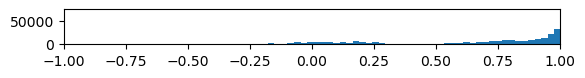

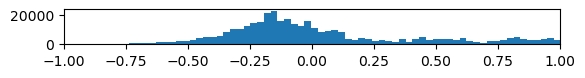

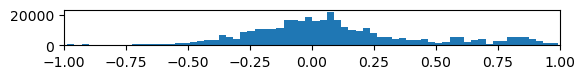

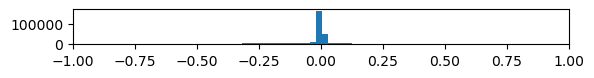

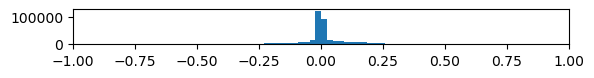

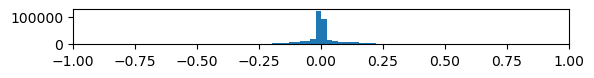

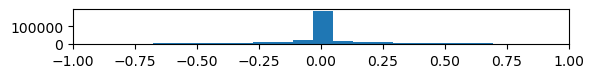

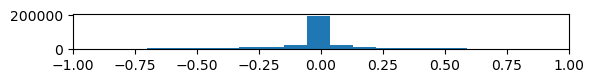

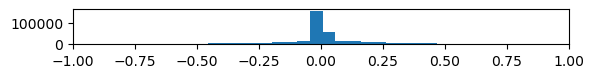

In [29]:
plot_variable_distributions(trainX)

We can say that this is close to Gaussian distribution and thus, apply the standardization of the data.

### Data Preprocesing

Normalize the dataset to deal with different ranges of each feature. 

In [12]:
# reshape the data to be used for scaler input

trainX = trainX.reshape((-1,128*9))
validX = validX.reshape((-1,128*9))
testX = testX.reshape((-1,128*9))

In [13]:
# standardize the dataset

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

motion_training_scaler = scaler.fit(trainX)
trainX = motion_training_scaler.transform(trainX)
validX = motion_training_scaler.transform(validX)
testX = motion_training_scaler.transform(testX)

In [14]:
# size has to be defined as (batch, n_timesteps, n_features) to be used for the input for neural network
trainX = trainX.reshape((-1,128,9))
validX = validX.reshape((-1,128,9))  
testX = testX.reshape((-1,128,9))

In [15]:
trainy = to_categorical(trainy)
validy = to_categorical(validy)
testy = to_categorical(testy)

In [34]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]

In [35]:
trainX.shape

(5955, 128, 9)

In [36]:
trainy.shape

(5955, 6)

## Model

### Defining and Compiling

In [46]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [22]:
pip install pydot graphviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 894.3 kB/s eta 0:00:000:00:01
Note: you may need to restart the kernel to use updated packages.


In [16]:
from tensorflow.keras.utils import plot_model
from tensorflow import keras
from keras.layers import Conv1D, GlobalAveragePooling1D, GlobalMaxPooling1D, MaxPooling1D, Dense, Dropout, Flatten
from keras import Model as Model_
from keras import regularizers

# define a model structure
class CNN_Model(Model_):
  def __init__(self): 
    super(CNN_Model, self).__init__()
    self.conv1 = Conv1D(32, 3, activation='relu')
    self.maxpool = MaxPooling1D()
    self.conv2 = Conv1D(32, 3, activation='relu')
    self.globalmaxpool = GlobalMaxPooling1D()  
    self.dropout = Dropout(0.2)
    self.outputLayer = Dense(6, activation='softmax')

  # to use the model 
  def call(self, input_x):
    output = input_x
    output = self.conv1(output)
    output = self.maxpool(output)
    output = self.conv2(output)
    output = self.globalmaxpool(output)
    output = self.dropout(output)
    return self.outputLayer(output)
  


In [17]:
# initiate a model instance
model  = CNN_Model()

In [18]:
model.compile(
    optimizer=keras.optimizers.Adam(),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.CategoricalCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.CategoricalAccuracy(name='accuracy')],
)

### Training

In [19]:
print("Fit model on training data")
history = model.fit(
    trainX,
    trainy,
    batch_size=64,
    epochs=100,
    validation_data=(validX, validy),
)

Fit model on training data
Epoch 1/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4641 - loss: 1.5197 - val_accuracy: 0.9041 - val_loss: 0.6105
Epoch 2/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9084 - loss: 0.4883 - val_accuracy: 0.9442 - val_loss: 0.2235
Epoch 3/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9396 - loss: 0.2058 - val_accuracy: 0.9442 - val_loss: 0.1457
Epoch 4/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9429 - loss: 0.1439 - val_accuracy: 0.9492 - val_loss: 0.1204
Epoch 5/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9529 - loss: 0.1216 - val_accuracy: 0.9563 - val_loss: 0.1113
Epoch 6/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9556 - loss: 0.1168 - val_accuracy: 0.9528 - val_loss: 0.1047
Epoch 7/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9531 - loss: 0.1101 - val_accuracy: 0.9528 - val_loss: 0.1019
Epoch 8/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9553 - loss: 0.1072

In [19]:
model.summary()

Model: "cnn__model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ ?                      │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,596 (49.21 KB)

 Trainable params: 4,198 (16.40 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,398 (32.81 KB)

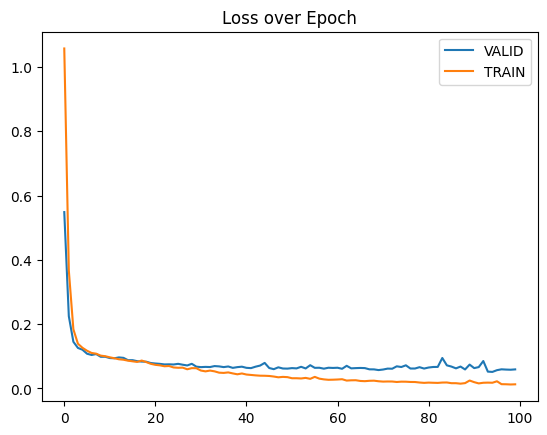

In [20]:
# print train and valid loss over epoch

plt.plot(history.history['val_loss'], label='VALID')
plt.plot(history.history['loss'], label='TRAIN')
plt.legend()
plt.title('Loss over Epoch')
plt.show()

## Results

In [21]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(testX, testy, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9343 - loss: 0.4518 
test loss, test acc: [0.4155012369155884, 0.9433321952819824]


## Further Experiments

### Hyperparameter Tuning with Keras Tuner

In [44]:
!pip install keras-tuner --upgrade

Looking in indexes: https://mirrors.sustech.edu.cn/pypi/web/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.5 MB/s eta 0:00:00


In [22]:
import keras_tuner

In [23]:
from tensorflow.keras import Sequential

In [24]:
def build_model(hp):
  model = Sequential()
  model.add(Conv1D(
      hp.Choice(name='filter1_size', values=[32, 64, 128]),
      hp.Choice(name='kernel1_size', values=[3, 5, 7]),
      activation='relu'))
  model.add(MaxPooling1D())  
  model.add(Conv1D(
      hp.Choice(name='filter2_size', values=[32, 64, 128]),
      hp.Choice(name='kernel2_size', values=[3, 5, 7]),
      activation='relu'))  
  if hp.Boolean(name="dropout"):
    model.add(Dropout(rate=0.2))
  model.add(GlobalMaxPooling1D())
  #model.add(Flatten())
  model.add(Dense(6, activation='softmax'))
  model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"],
    )
  return model

In [25]:
build_model(keras_tuner.HyperParameters())

<Sequential name=sequential, built=False>

In [26]:
tuner = keras_tuner.GridSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    overwrite=True)

In [27]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
filter1_size (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128], 'ordered': True}
kernel1_size (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5, 7], 'ordered': True}
filter2_size (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128], 'ordered': True}
kernel2_size (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5, 7], 'ordered': True}
dropout (Boolean)
{'default': False, 'conditions': []}


In [28]:
tuner.search(trainX, trainy, epochs=5, validation_data=(validX, validy))

Trial 5 Complete [00h 00m 02s]
val_accuracy: 0.9613457322120667

Best val_accuracy So Far: 0.9649248123168945
Total elapsed time: 00h 00m 12s


In [29]:
best_model = tuner.get_best_models()[0]

/Users/wangxiaoxuan/anaconda3/envs/ml_py3.9/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [30]:
best_model.build(input_shape=(None, 128, 9))
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 126, 32)        │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 63, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 59, 32)         │         5,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 59, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 32)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,246 (24.40 KB)

 Trainable params: 6,246 (24.40 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 3 summary
Hyperparameters:
filter1_size: 32
kernel1_size: 3
filter2_size: 32
kernel2_size: 5
dropout: True
Score: 0.9649248123168945

Trial 1 summary
Hyperparameters:
filter1_size: 32
kernel1_size: 3
filter2_size: 32
kernel2_size: 3
dropout: True
Score: 0.9613457322120667

Trial 4 summary
Hyperparameters:
filter1_size: 32
kernel1_size: 3
filter2_size: 32
kernel2_size: 7
dropout: False
Score: 0.9613457322120667

Trial 0 summary
Hyperparameters:
filter1_size: 32
kernel1_size: 3
filter2_size: 32
kernel2_size: 3
dropout: False
Score: 0.9577666521072388

Trial 2 summary
Hyperparameters:
filter1_size: 32
kernel1_size: 3
filter2_size: 32
kernel2_size: 5
dropout: False
Score: 0.9541875720024109
